# Importation librairies

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import gc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import function_preprocessing

# feature enginering

In [2]:
num_rows = None
df = function_preprocessing.application_train_test(num_rows)
with function_preprocessing.timer("Process bureau and bureau_balance"):
    bureau = function_preprocessing.bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with function_preprocessing.timer("Process previous_applications"):
    prev = function_preprocessing.previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with function_preprocessing.timer("Process POS-CASH balance"):
    pos = function_preprocessing.pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with function_preprocessing.timer("Process installments payments"):
    ins = function_preprocessing.installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with function_preprocessing.timer("Process credit card balance"):
    cc = function_preprocessing.credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

df.rename(columns=lambda x: function_preprocessing.nettoyer_nom_colonne(x), inplace=True)

print(df.shape)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 32s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 55s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 23s
Installments payments df shape: (339587, 26)
Process installments payments - done in 35s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 25s
(356251, 796)


In [3]:
df_temp = df.copy()

In [4]:
df_temp = function_preprocessing.suppression_nan(df_temp, threshold_col=0.6, threshold_row=1)
X_train, X_test, y_train, y_test = function_preprocessing.spliting_df(df_temp, test_size=0.33)

Suppression de 26 colonnes, 356251 colonnes restantes
Suppression de 48744 lignes, 307507 lignes restantes
Suppression de 206 colonnes ayant plus de 60.0% de valeurs manquantes, 564 colonnes restantes
Suppression de 0 lignes, 307507 lignes restantes


In [5]:
sel = SelectFromModel(LGBMClassifier(objective = "binary", boosting_type = "gbdt", n_estimators = 100, random_state=48))
sel.fit(X_train, y_train)

selected_feat= X_train.columns[(sel.get_support())]
print(f"\nNombre de features sélectionnées : {len(selected_feat)}")

[LightGBM] [Info] Number of positive: 16619, number of negative: 189410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.656313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61997
[LightGBM] [Info] Number of data points in the train set: 206029, number of used features: 551
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080663 -> initscore=-2.433367
[LightGBM] [Info] Start training from score -2.433367

Nombre de features sélectionnées : 157


In [6]:
print(selected_feat)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_AMT_INSTALMENT_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_MIN',
       'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MEAN',
       'INSTAL_AMT_PAYMENT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM'],
      dtype='object', length=157)


# Feature selection

In [7]:
X = df_temp[selected_feat]
y = df_temp['TARGET']

In [8]:
model = LGBMClassifier(objective="binary", boosting_type="gbdt", n_estimators=100, random_state=48)
model.fit(X, y)

importance = model.feature_importances_
feature_names = X.columns
feature_importance = list(zip(feature_names, importance))
feature_importance.sort(key=lambda x: x[1], reverse=True)
sorted_feature_names = [f[0] for f in feature_importance]
sorted_importance = [f[1] for f in feature_importance]

for i, (feature, score) in enumerate(feature_importance):
    print(f"Feature {i+1}: {feature}, Score: {score:.5f}")

[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32844
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471
Feature 1: EXT_SOURCE_1, Score: 160.00000
Feature 2: PAYMENT_RATE, Score: 136.00000
Feature 3: EXT_SOURCE_3, Score: 117.00000
Feature 4: EXT_SOURCE_2, Score: 109.00000
Feature 5: DAYS_BIRTH, Score: 79.00000
Feature 6: ACTIVE_DAYS_CREDIT_MAX, Score: 63.00000
Feature 7: AMT_ANNUITY, Score: 60.00000
Feature 8: APPROVED_CNT_PAYMENT_MEAN, Score: 47.00000
Feature 9: INSTAL_DAYS_ENTRY_PAYMENT_MEAN, Score: 46.00000
Feature 10: INSTAL_DPD_MEAN, Score: 45.00000
Feature 11: DAYS_EMPLOYED, Score: 44.00000
Fea

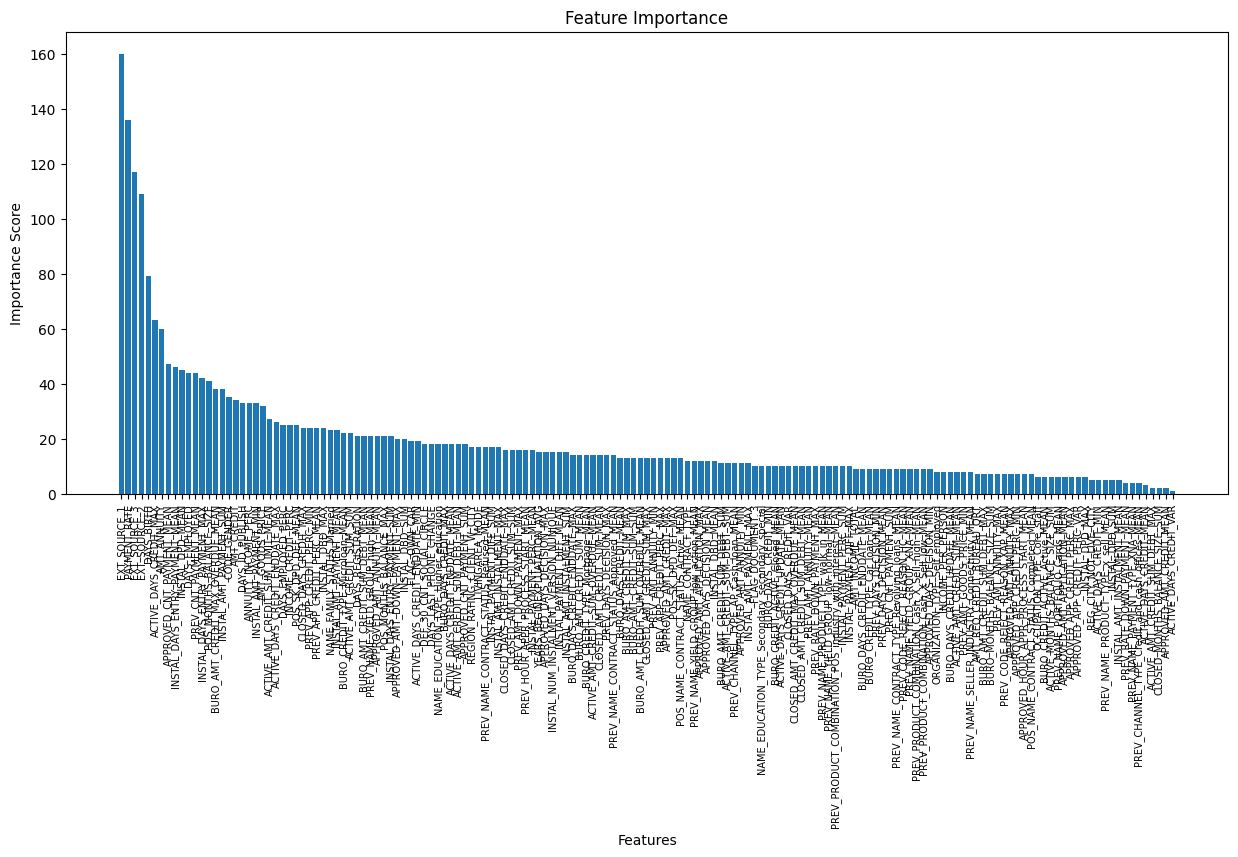

In [9]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(sorted_importance)), sorted_importance, tick_label=sorted_feature_names)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.show()

In [10]:
# Importance en dessous de 30
sorted_feature_names[:29]

['EXT_SOURCE_1',
 'PAYMENT_RATE',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'ACTIVE_DAYS_CREDIT_MAX',
 'AMT_ANNUITY',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN',
 'DAYS_EMPLOYED',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'POS_MONTHS_BALANCE_SIZE',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'CODE_GENDER',
 'AMT_CREDIT',
 'DAYS_ID_PUBLISH',
 'ANNUITY_INCOME_PERC',
 'INSTAL_AMT_PAYMENT_MIN',
 'AMT_GOODS_PRICE',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'POS_SK_DPD_DEF_MEAN',
 'CLOSED_DAYS_CREDIT_MAX',
 'PREV_APP_CREDIT_PERC_MIN']

In [11]:
selected_features = sorted_feature_names[:29] + ['TARGET']
df = df[selected_features]

In [12]:
correlations = df.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(16))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 INCOME_CREDIT_PERC                 -0.001816
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN    0.002435
POS_SK_DPD_DEF_MEAN                 0.006496
INSTAL_DPD_MEAN                     0.008903
APPROVED_CNT_PAYMENT_MEAN           0.012394
PAYMENT_RATE                        0.012703
ANNUITY_INCOME_PERC                 0.014262
CLOSED_DAYS_CREDIT_MAX              0.027435
PREV_CNT_PAYMENT_MEAN               0.027744
INSTAL_DAYS_ENTRY_PAYMENT_MEAN      0.043992
ACTIVE_DAYS_CREDIT_ENDDATE_MAX      0.044414
DAYS_ID_PUBLISH                     0.051457
ACTIVE_DAYS_CREDIT_MAX              0.060414
DAYS_EMPLOYED                       0.074957
DAYS_BIRTH                          0.078242
TARGET                              1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                       -0.178926
EXT_SOURCE_2                       -0.160471
EXT_SOURCE_1                       -0.155317
DAYS_EMPLOYED_PERC                 -0.067952
CODE_GENDER 

In [13]:
rows_to_drop = df['TARGET'].index[df['TARGET'].isnull()].tolist()
df.drop(index=rows_to_drop, inplace=True)

In [15]:
df.dtypes.value_counts()

float64    27
int64       3
Name: count, dtype: int64

In [29]:
df.to_csv('./data/cleaned_df.csv', encoding='utf-8', sep=';', index=False)

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
